In [3]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Spark_Colab") \
    .getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 MB 36.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyspark: filename=pyspark-3.5.5-py2.py3-none-any.whl size=317747923 sha256=fed108c89999eebc7cac336be11df5d289c49151999c030ae908809ef18025f6
  Stored in directory: /Users/stefano/Library/Caches/pip/wheels/9a/81/ff/d0378800053965023f8bdd676d306e93104e948cea3d1d5e70
Successfully built pyspark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/28 10:59:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
import os
import pandas as pd

# Set base path to GitHub folder structure
base_path = "Data/Barcelona"

# File paths for all datasets
accidents_path = f"{base_path}/accidents_2017.csv"
air_quality_path = f"{base_path}/air_quality_Nov2017.csv"
air_station_path = f"{base_path}/air_stations_Nov2017.csv"
birth_path = f"{base_path}/births.csv"
bus_stop_path = f"{base_path}/bus_stops.csv"
deaths_path = f"{base_path}/deaths.csv"
immigrants_path = f"{base_path}/immigrants_by_nationality.csv"
life_expectancy_path = f"{base_path}/life_expectancy.csv"
most_frequent_name_path = f"{base_path}/most_frequent_names.csv"
population_path = f"{base_path}/population.csv"
transport_path = f"{base_path}/transports.csv"
unemployment_path = f"{base_path}/unemployment.csv"

# Load datasets as DataFrames
accidents_df = spark.read.format("csv").option("header", "true").load(accidents_path)
air_quality_df = spark.read.format("csv").option("header", "true").load(air_quality_path)
air_station_df = spark.read.format("csv").option("header", "true").load(air_station_path)
birth_df = spark.read.format("csv").option("header", "true").load(birth_path)
bus_stop_df = spark.read.format("csv").option("header", "true").load(bus_stop_path)
deaths_df = spark.read.format("csv").option("header", "true").load(deaths_path)
immigrants_df = spark.read.format("csv").option("header", "true").load(immigrants_path)
life_expectancy_df = spark.read.format("csv").option("header", "true").load(life_expectancy_path)
most_frequent_name_df = spark.read.format("csv").option("header", "true").load(most_frequent_name_path)
population_df = spark.read.format("csv").option("header", "true").load(population_path)
transport_df = spark.read.format("csv").option("header", "true").load(transport_path)
unemployment_df = spark.read.format("csv").option("header", "true").load(unemployment_path)

#QUERY 1: Identify the Top 5 Intersections with the Most Traffic Accidents

In [5]:
from pyspark.sql.functions import col, count, desc

# Group by street to count the number of accidents per street
accidents_count = (
    accidents_df.groupBy("street")
    .agg(count("id").alias("accident_count"))  # Count the number of accidents per street
    .orderBy(desc("accident_count"))  # Sort in descending order by accident count
)

# Get the top 5 streets with the most accidents
top_5_streets = accidents_count.limit(5)

# Show the results
top_5_streets.show()


+--------------------+--------------+
|              street|accident_count|
+--------------------+--------------+
|Corts Catalanes  ...|           219|
|Diagonal         ...|           176|
|Litoral (Llobrega...|           116|
|Litoral (Besòs)  ...|            99|
|Aragó            ...|            95|
+--------------------+--------------+



#QUERY 2: Get the average life expectancy for each district, broken down by gender (further findings)


+-------------+--------------------+------+-------------------+
|District Name|   Neighborhood Name|Gender|avg_life_expectancy|
+-------------+--------------------+------+-------------------+
| Ciutat Vella|Sant Pere, Santa ...|Female|              86.34|
| Ciutat Vella|Sant Pere, Santa ...|  Male|              78.74|
| Ciutat Vella|      el Barri Gòtic|Female|              85.72|
| Ciutat Vella|      el Barri Gòtic|  Male|               79.4|
| Ciutat Vella|            el Raval|Female|              85.46|
| Ciutat Vella|            el Raval|  Male|              76.28|
| Ciutat Vella|      la Barceloneta|Female|              85.78|
| Ciutat Vella|      la Barceloneta|  Male|              76.72|
|     Eixample|         Sant Antoni|Female|              87.08|
|     Eixample|         Sant Antoni|  Male|              80.22|
|     Eixample|       el Fort Pienc|Female|              87.68|
|     Eixample|       el Fort Pienc|  Male|              81.24|
|     Eixample|l'Antiga Esquerra...|Fema

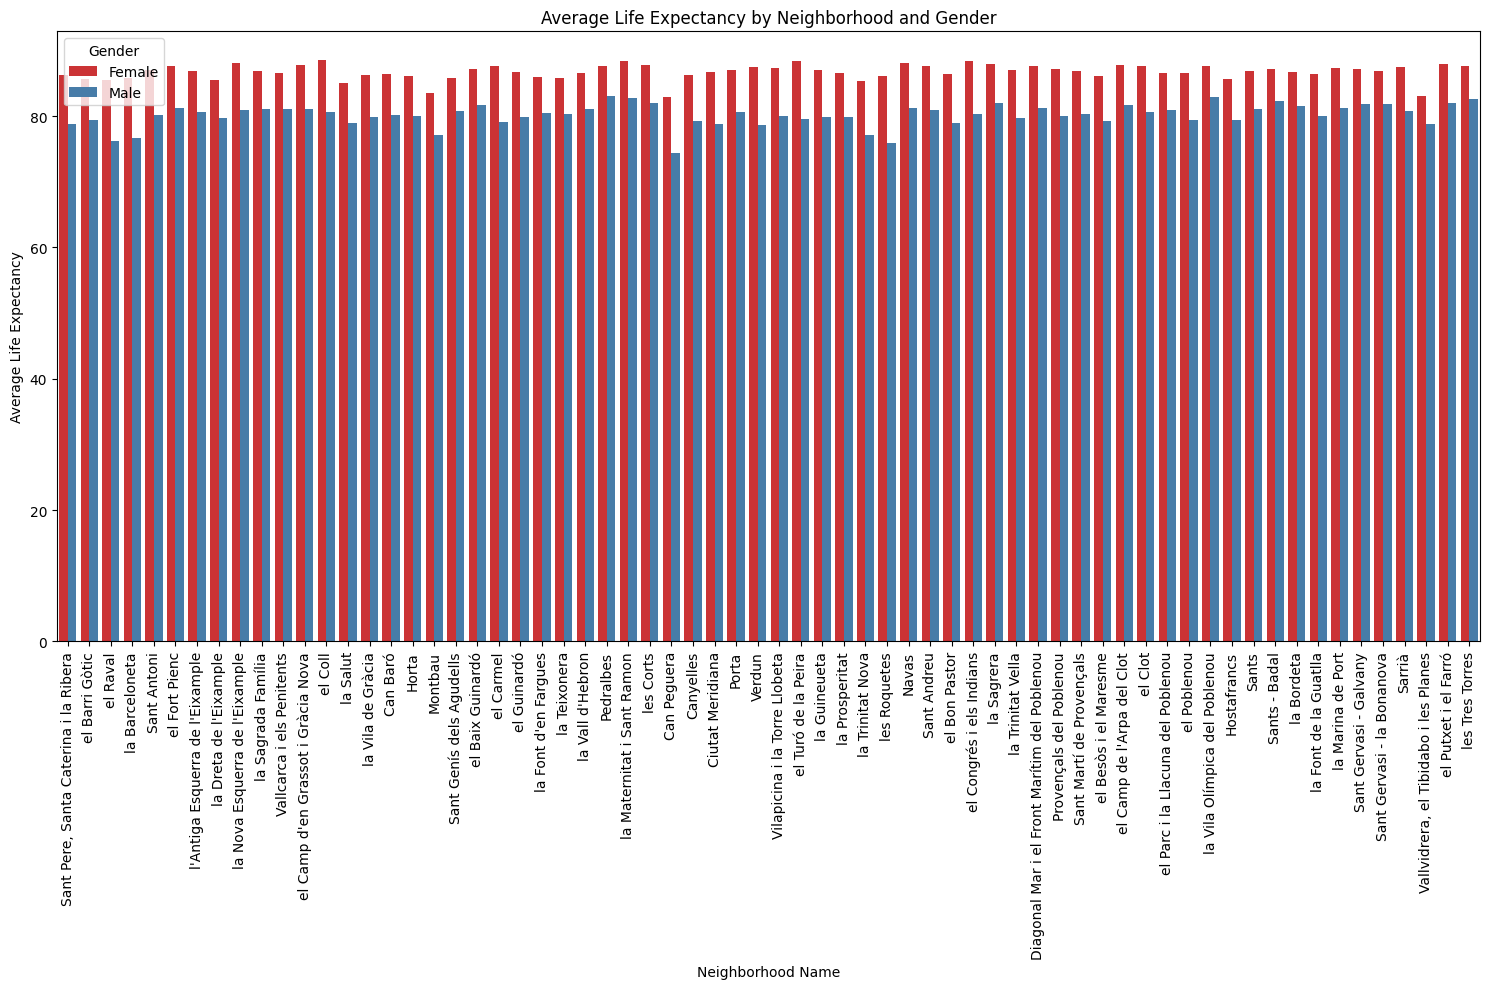

In [6]:
from pyspark.sql.functions import avg, round, col

# Rename columns for consistency
population_df = population_df.withColumnRenamed("Neighborhood.Name", "Neighborhood Name")
population_df = population_df.withColumnRenamed("District.Name", "District Name")

# Join life_expectancy with population to get District Name and Neighborhood Name
life_expectancy_with_districts = life_expectancy_df.join(
    population_df,
    life_expectancy_df["Neighborhood"] == population_df["Neighborhood Name"],
    "inner"
).select(
    population_df["District Name"].alias("District Name"),
    population_df["Neighborhood Name"].alias("Neighborhood Name"),
    life_expectancy_df["Gender"],
    life_expectancy_df["2006-2010"],
    life_expectancy_df["2007-2011"],
    life_expectancy_df["2008-2012"],
    life_expectancy_df["2009-2013"],
    life_expectancy_df["2010-2014"]
)

# Filter out rows with NULL or 0 in any of the life expectancy columns
filtered_life_expectancy = life_expectancy_with_districts.filter(
    (col("2006-2010").isNotNull()) & (col("2006-2010") > 0) &
    (col("2007-2011").isNotNull()) & (col("2007-2011") > 0) &
    (col("2008-2012").isNotNull()) & (col("2008-2012") > 0) &
    (col("2009-2013").isNotNull()) & (col("2009-2013") > 0) &
    (col("2010-2014").isNotNull()) & (col("2010-2014") > 0)
)

# Combine life expectancy across all years into a single average
avg_life_expectancy = (
    filtered_life_expectancy.groupBy("District Name", "Neighborhood Name", "Gender")
    .agg(
        round(
            avg(
                col("2006-2010") +
                col("2007-2011") +
                col("2008-2012") +
                col("2009-2013") +
                col("2010-2014")
            ) / 5, 2
        ).alias("avg_life_expectancy")
    )
    .orderBy("District Name", "Neighborhood Name", "Gender")
)

avg_life_expectancy.show()



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transform from DataFrame of PySpark to Pandas
avg_life_expectancy_pd = avg_life_expectancy.toPandas()

# Set up the plot size
plt.figure(figsize=(15, 10))

# Use Seaplot to make the plot
sns.barplot(
    data=avg_life_expectancy_pd,
    x="Neighborhood Name",
    y="avg_life_expectancy",
    hue="Gender",
    palette="Set1"
)

# Do rotation to improve readability
plt.xticks(rotation=90)

# Add tags and title
plt.xlabel("Neighborhood Name")
plt.ylabel("Average Life Expectancy")
plt.title("Average Life Expectancy by Neighborhood and Gender")
plt.legend(title="Gender")

# Adjust the design to avoid cuts
plt.tight_layout()

# Show the graph
plt.show()


#QUERY 3: Find the district with the highest NO2 pollution value in air quality.

In [7]:
from pyspark.sql.functions import col, max

# Join air_quality and air_station DataFrames on the station column
air_quality_with_districts = air_quality_df.join(
    air_station_df, "Station", "inner"
).withColumn("NO2 Value", col("NO2 Value").cast("double"))

# Filter out null values
filtered_data = air_quality_with_districts.filter(col("NO2 Value").isNotNull())

# Find the maximum NO2 value
max_no2_value = filtered_data.agg(max("NO2 Value").alias("max_no2")).collect()[0]["max_no2"]

# Select districts with the maximum NO2 value
highest_no2_district = filtered_data.filter(col("NO2 Value") == max_no2_value).select("District Name", "NO2 Value")

# Show the results
highest_no2_district.show()

+-------------+---------+
|District Name|NO2 Value|
+-------------+---------+
|       Gracia|    117.0|
+-------------+---------+



#QUERY 4: Calculate the unemployment rate by gender in each neighborhood for a specific month and yea, and then compare it to the average of that specific year. (further findings)

Unemployment Rate for January 2017:


+----+-------+--------------------+------+-----------------+
|year|  month|   Neighborhood Name|gender|unemployment_rate|
+----+-------+--------------------+------+-----------------+
|2017|January|       Baró de Viver|Female|             7.06|
|2017|January|       Baró de Viver|  Male|             5.44|
|2017|January|            Can Baró|Female|             5.13|
|2017|January|            Can Baró|  Male|             4.81|
|2017|January|         Can Peguera|Female|             6.14|
|2017|January|         Can Peguera|  Male|             6.35|
|2017|January|           Canyelles|Female|             8.14|
|2017|January|           Canyelles|  Male|             8.16|
|2017|January|    Ciutat Meridiana|Female|             10.8|
|2017|January|    Ciutat Meridiana|  Male|            11.93|
|2017|January|Diagonal Mar i el...|Female|             6.52|
|2017|January|Diagonal Mar i el...|  Male|             6.34|
|2017|January|               Horta|Female|              6.4|
|2017|January|          

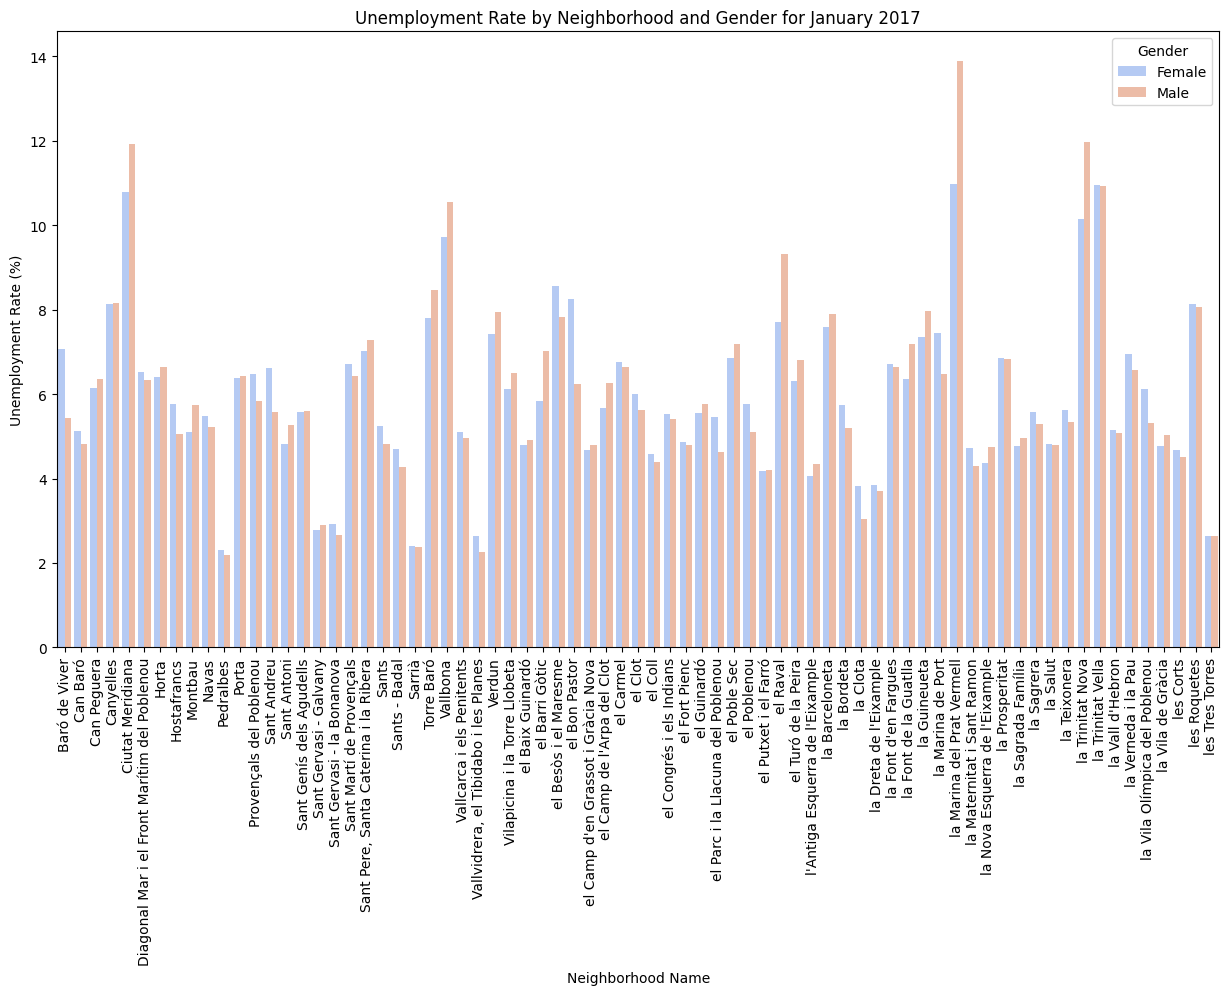

Average unemployment Rate for 2017:
+----+--------------------+------+---------------------+
|year|   Neighborhood Name|gender|avg_unemployment_rate|
+----+--------------------+------+---------------------+
|2017|       Baró de Viver|Female|                 6.73|
|2017|       Baró de Viver|  Male|                  5.0|
|2017|            Can Baró|Female|                 4.99|
|2017|            Can Baró|  Male|                 4.48|
|2017|         Can Peguera|Female|                 6.02|
|2017|         Can Peguera|  Male|                 5.88|
|2017|           Canyelles|Female|                 8.06|
|2017|           Canyelles|  Male|                  7.4|
|2017|    Ciutat Meridiana|Female|                10.89|
|2017|    Ciutat Meridiana|  Male|                11.03|
|2017|Diagonal Mar i el...|Female|                 6.27|
|2017|Diagonal Mar i el...|  Male|                 5.92|
|2017|               Horta|Female|                 6.28|
|2017|               Horta|  Male|                  

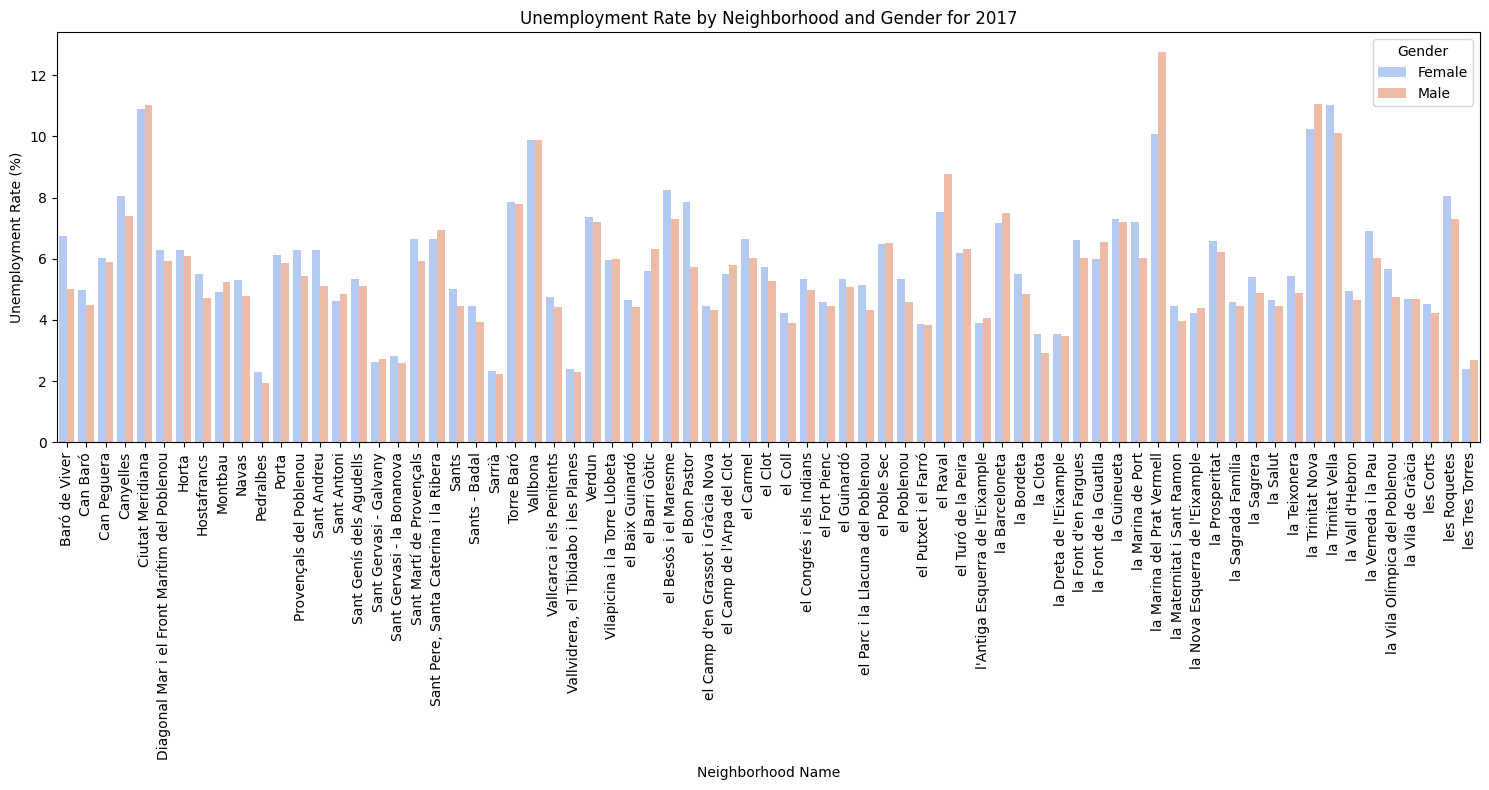

In [8]:
from pyspark.sql.functions import col, sum, round

# Define constants for the specific month and year
specific_year = 2017
specific_month = "January"


# Filter and pre-aggregate population data for individuals aged 18 and above
population_workable_sum = (
    population_df.filter(~col("Age").isin("0-4", "5-9", "10-14"))  # Exclude age groups below 18
    .groupBy("Year", "Neighborhood Name", "Gender")
    .agg(sum("Number").alias("population_workable"))
)

# Filter unemployment data for the specific month, year, and "Registered unemployed"
unemployment_filtered_january = unemployment_df.filter(
    (col("year") == specific_year) &
    (col("month") == specific_month) &
    (col("Demand_occupation") == "Registered unemployed")
)
# Perform the join and calculate unemployment rate

result_january = (
    unemployment_filtered_january.join(
        population_workable_sum,
        on=["Year", "Neighborhood Name", "Gender"],
        how="inner"
    )
    .withColumn(
        "unemployment_rate",
        round((col("number") / col("population_workable")) * 100, 2)
    )
    .select("year", "month", "Neighborhood Name", "gender", "unemployment_rate").orderBy("Neighborhood Name", "gender"))

print("Unemployment Rate for January 2017:")
result_january.show()


import matplotlib.pyplot as plt
import seaborn as sns

#DataFrame from PySpark to Pandas
result_january_pd = result_january.toPandas()

# fix the size
plt.figure(figsize=(15, 8))

# create a group bar plot with sns
sns.barplot(
    data=result_january_pd,
    x="Neighborhood Name",
    y="unemployment_rate",
    hue="gender",
    palette="coolwarm"
)

#format the graph
plt.xticks(rotation=90)
plt.xlabel("Neighborhood Name")
plt.ylabel("Unemployment Rate (%)")
plt.title(f"Unemployment Rate by Neighborhood and Gender for {specific_month} {specific_year}")
plt.legend(title="Gender")

# show the graph
plt.show()

#Resut of 2017 overall

# Filter unemployment data for the specific year, and "Registered unemployed"
unemployment_filtered = unemployment_df.filter(
    (col("year") == specific_year) &
    (col("Demand_occupation") == "Registered unemployed")
)

#join and print result for the entire year

result = (
    unemployment_filtered.join(
        population_workable_sum,
        on=["Year", "Neighborhood Name", "Gender"],
        how="inner"
    )
    .withColumn(
        "unemployment_rate",
        round((col("number") / col("population_workable")) * 100, 2)
    )
    .groupBy("year", "Neighborhood Name", "gender")
    .agg(round(avg("unemployment_rate"), 2).alias("avg_unemployment_rate"))
    .orderBy("Neighborhood Name", "gender")
)
print("Average unemployment Rate for 2017:")
result.show()

#DataFrame from PySpark to Pandas
result_pd = result.toPandas()

# Adjust the graph size
plt.figure(figsize=(15, 8))

# Use seaborn to create the graph
sns.barplot(
    data=result_pd,
    x="Neighborhood Name",
    y="avg_unemployment_rate",
    hue="gender",
    palette="coolwarm"
)

# Rotate the labels for better picture
plt.xticks(rotation=90)

# Add tags and title
plt.xlabel("Neighborhood Name")
plt.ylabel("Unemployment Rate (%)")
plt.title(f"Unemployment Rate by Neighborhood and Gender for {specific_year}")
plt.legend(title="Gender")

plt.tight_layout()

# show the graph
plt.show()

#QUERY 5: ⁠Identify the 5 neighborhoods with the highest birth rates in the last 4 years



In [9]:
# Filter out the last 4 years

births_last_five_years = birth_df.filter(birth_df["Year"].isin(2017, 2016, 2015, 2014))

# Find the sum of births per neigborhood and order them
birth_count = births_last_five_years.groupBy("Neighborhood Name").agg(sum("Number").alias("total_births")).orderBy(desc("total_births"))

# Include only the top 5
Top_5_neighborhoods = birth_count.limit(5)

print("Top 5 neighborhoods with the highest birth rates in the last 4 years:")
Top_5_neighborhoods.show()






Top 5 neighborhoods with the highest birth rates in the last 4 years:
+--------------------+------------+
|   Neighborhood Name|total_births|
+--------------------+------------+
|         Sant Andreu|      1923.0|
|   la Vila de Gràcia|      1903.0|
|            el Raval|      1812.0|
|la Nova Esquerra ...|      1804.0|
|Sant Gervasi - Ga...|      1617.0|
+--------------------+------------+



#QUERY 6: Identify districts with the worst air quality index (AQI)

In [10]:
from pyspark.sql.functions import col, avg

# Join air_quality and air_station DataFrames on the "Station" column
air_quality_with_districts = air_quality_df.join(
    air_station_df, "Station", "inner"
).withColumn("NO2_Value", col("NO2 Value").cast("double")) \
 .withColumn("O3_Value", col("O3 Value").cast("double"))

# Filter out rows with null values for NO2 or O3
filtered_data = air_quality_with_districts.filter(
    col("NO2_Value").isNotNull() & col("O3_Value").isNotNull()
)

# Calculate the average NO2 and O3 values for each district
district_aqi = filtered_data.groupBy("District Name") \
    .agg(
        avg("NO2_Value").alias("avg_NO2"),
        avg("O3_Value").alias("avg_O3")
    ) \
    .withColumn("AQI", (col("avg_NO2") + col("avg_O3")) / 2)

# Order districts by AQI in descending order
worst_aqi_districts = district_aqi.orderBy(col("AQI").desc())

# Show the results
worst_aqi_districts.select("District Name", "AQI").show()


+--------------+------------------+
| District Name|               AQI|
+--------------+------------------+
|      Eixample| 36.62810559006211|
|        Gracia|            35.625|
|Horta-Guinardo| 33.59001406469761|
|  Ciutat Vella| 32.49215406562054|
|     Les Corts|29.997860199714694|
+--------------+------------------+



#QUERY 7: Identify the top 3 districts with the Lowest death counts for individuals above 80 years of age between 2016 and 2017.

In [11]:
from pyspark.sql.functions import col, sum, desc, asc

# Filter deaths for individuals above 80 years of age and within 2016 and 2017
deaths_filtered = deaths_df.filter(
    (col("Age").isin("80-84", "85-89", "90-94", ">=95")) &  # Include age groups above 80
    (col("Year").between(2016, 2017))  # Filter between 2016 and 2017
)

deaths_filtered = deaths_filtered.withColumnRenamed("District.Name", "District Name")


# Calculate total deaths per district
district_death_counts = (
    deaths_filtered.groupBy("District Name")
    .agg(sum("Number").alias("total_deaths"))
    .orderBy(asc("total_deaths"))
)

# Get the top 3 districts with the highest death counts
top_3_districts = district_death_counts.limit(3)

# Show the results
top_3_districts.show()


+-------------+------------+
|District Name|total_deaths|
+-------------+------------+
| Ciutat Vella|       835.0|
|    Les Corts|       879.0|
|       Gràcia|      1372.0|
+-------------+------------+



#QUERY 8: Determine the relationship between air quality index (AQI) and traffic accident rates in districts. 

In [12]:
from pyspark.sql.functions import col, avg, count

# Step 1: Calculate AQI for each district
air_quality_with_districts = air_quality_df.join(
    air_station_df, "Station", "inner"
).withColumn("NO2_Value", col("NO2 Value").cast("double")) \
 .withColumn("O3_Value", col("O3 Value").cast("double"))

filtered_data = air_quality_with_districts.filter(
    col("NO2_Value").isNotNull() & col("O3_Value").isNotNull()
)

district_aqi = filtered_data.groupBy("District Name") \
    .agg(
        avg("NO2_Value").alias("avg_NO2"),
        avg("O3_Value").alias("avg_O3")
    ) \
    .withColumn("AQI", (col("avg_NO2") + col("avg_O3")) / 2)

# Step 2: Calculate traffic accident rates by district
accidents_by_district = accidents_df.groupBy("District Name").agg(
    count("id").alias("accident_count")
)

# Step 3: Join AQI and traffic accident data
aqi_accidents_by_district = district_aqi.join(
    accidents_by_district,
    on="District Name",
    how="inner"
)

# Step 4: Calculate correlation between AQI and accident rates
correlation = aqi_accidents_by_district.stat.corr("AQI", "accident_count")

# Show results
print(f"Correlation between AQI and traffic accident rates: {correlation}")

# Optional: Display the joined data
aqi_accidents_by_district.orderBy(col("AQI").desc()).show()


Correlation between AQI and traffic accident rates: 0.9099241744349007
+-------------+-----------------+------------------+------------------+--------------+
|District Name|          avg_NO2|            avg_O3|               AQI|accident_count|
+-------------+-----------------+------------------+------------------+--------------+
|     Eixample|56.24068322981366| 17.01552795031056| 36.62810559006211|          3029|
| Ciutat Vella|39.85592011412268|25.128388017118404| 32.49215406562054|           600|
|    Les Corts|27.97432239657632| 32.02139800285307|29.997860199714694|           726|
+-------------+-----------------+------------------+------------------+--------------+



#QUERY 9: Compare Districts' Air Pollution (NO2, O3 Levels) with Average Life Expectancy (half in normal, half in further findings)

Correlation (median_NO2, life_expectancy): -0.08167446309742804
Correlation (median_O3, life_expectancy):  0.06737049509757972
Correlation (pollution_index, life_expectancy): -0.07961453189794497


25/02/28 11:04:05 WARN Instrumentation: [a389a919] regParam is zero, which might cause numerical instability and overfitting.
25/02/28 11:04:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/02/28 11:04:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Regression coefficient: [-0.12614841]
Regression intercept: 88.04194346289422
R^2: 0.006338473689328161


Neighborhoods with worst combined (high pollution, low life expectancy):


25/02/28 11:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 1

+-------------------------------------+----------+---------+---------------+-------------------+--------------+---------+
|neighborhood                         |median_NO2|median_O3|pollution_index|avg_life_expectancy|pollution_rank|life_rank|
+-------------------------------------+----------+---------+---------------+-------------------+--------------+---------+
|la Nova Esquerra de l'Eixample       |54.0      |14.0     |34.0           |80.88              |1             |4        |
|Sant Pere, Santa Caterina i la Ribera|40.0      |22.0     |31.0           |86.34              |3             |3        |
|la Vall d'Hebron                     |26.0      |40.0     |33.0           |86.56              |2             |2        |
|Pedralbes                            |22.0      |35.0     |28.5           |87.64              |4             |1        |
+-------------------------------------+----------+---------+---------------+-------------------+--------------+---------+

Neighborhoods with best

25/02/28 11:04:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 11:04:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/28 1

+--------------------+----------+---------+---------------+-------------------+--------------+---------+
|        neighborhood|median_NO2|median_O3|pollution_index|avg_life_expectancy|pollution_rank|life_rank|
+--------------------+----------+---------+---------------+-------------------+--------------+---------+
|           Pedralbes|      22.0|     35.0|           28.5|              87.64|             4|        1|
|    la Vall d'Hebron|      26.0|     40.0|           33.0|              86.56|             2|        2|
|Sant Pere, Santa ...|      40.0|     22.0|           31.0|              86.34|             3|        3|
|la Nova Esquerra ...|      54.0|     14.0|           34.0|              80.88|             1|        4|
+--------------------+----------+---------+---------------+-------------------+--------------+---------+



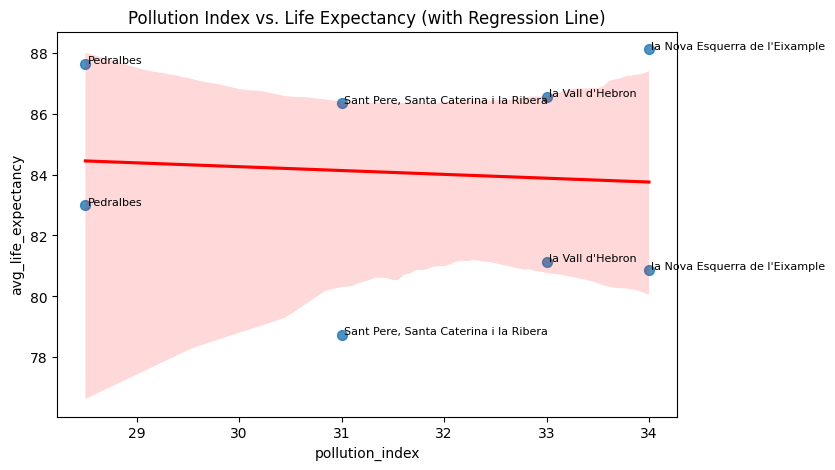

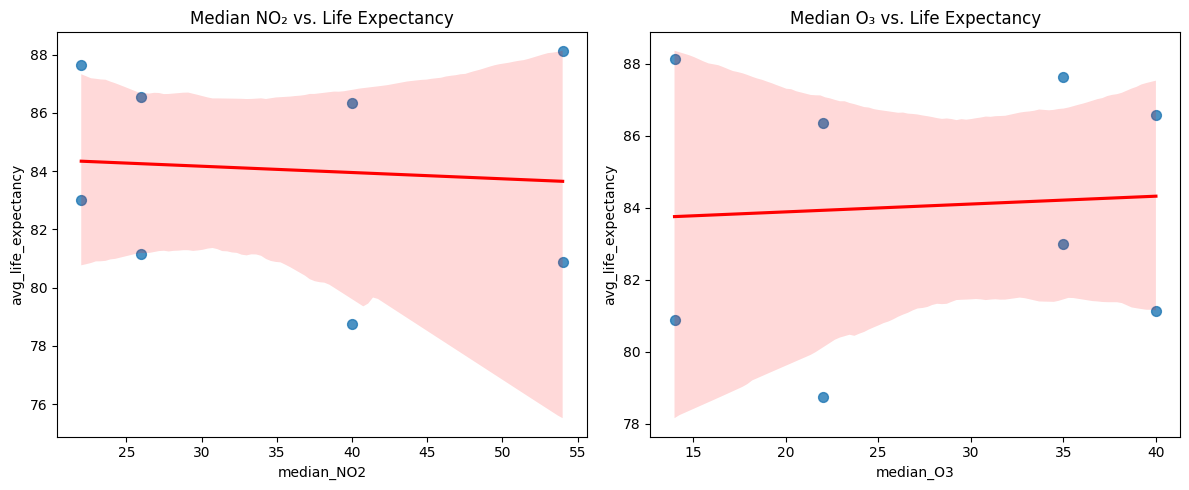

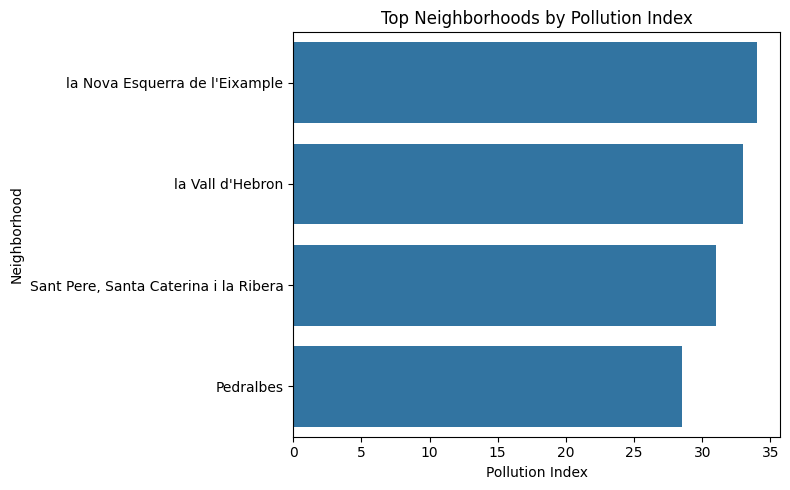

In [13]:
from pyspark.sql.functions import col, expr, row_number, desc
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd


#------------------------------------------------#
# STEP 1: Join air-quality and station data       #
#------------------------------------------------#

air_quality_with_neighborhood = (
    air_quality_df.join(
        air_station_df,
        air_quality_df["station"] == air_station_df["Station"],
        "inner"
    )
    .select(
        air_station_df["Neighborhood Name"].alias("Neighborhood"),
        air_quality_df["NO2 Value"].cast("double").alias("NO2_Value"),
        air_quality_df["O3 Value"].cast("double").alias("O3_Value")
    )
)

#-----------------------------------------------------------------#
# STEP 2: Compute median NO2 and O3 for each neighborhood         #
#-----------------------------------------------------------------#
pollution_medians = (
    air_quality_with_neighborhood
    .groupBy("Neighborhood")
    .agg(
        F.expr("percentile_approx(NO2_Value, 0.5)").alias("median_NO2"),
        F.expr("percentile_approx(O3_Value, 0.5)").alias("median_O3")
    )
)

#---------------------------------------------------------------------------#
# STEP 3: Filter out outliers (5th–95th percentile range for medians)       #
#---------------------------------------------------------------------------#
quantiles_no2 = pollution_medians.approxQuantile("median_NO2", [0.05, 0.95], 0.0)
quantiles_o3 = pollution_medians.approxQuantile("median_O3", [0.05, 0.95], 0.0)

pollution_filtered = pollution_medians.filter(
    (col("median_NO2") >= quantiles_no2[0]) & (col("median_NO2") <= quantiles_no2[1]) &
    (col("median_O3") >= quantiles_o3[0]) & (col("median_O3") <= quantiles_o3[1])
)

#-----------------------------------------------------------------------------------#
# STEP 4: Combine NO2 and O3 into a single 'pollution_index' (simple average here)   #
#-----------------------------------------------------------------------------------#
pollution_index_df = pollution_filtered.withColumn(
    "pollution_index", (col("median_NO2") + col("median_O3")) / 2
)

#----------------------------------------------------------#
# STEP 5: Join with life expectancy to get full dataset    #
#----------------------------------------------------------#

pollution_life_expectancy = pollution_index_df.join(
    avg_life_expectancy,
    pollution_index_df["Neighborhood"] == avg_life_expectancy["Neighborhood Name"],
    "inner"
).select(
    col("Neighborhood Name").alias("neighborhood"),
    col("median_NO2"),
    col("median_O3"),
    col("pollution_index"),
    col("avg_life_expectancy")
)


#--------------------------------------------------------------#
# STEP 6: Calculate correlations (NO2, O3, index vs. life)     #
#--------------------------------------------------------------#
correlation_no2_life = pollution_life_expectancy.stat.corr("median_NO2", "avg_life_expectancy")
correlation_o3_life = pollution_life_expectancy.stat.corr("median_O3", "avg_life_expectancy")
correlation_index_life = pollution_life_expectancy.stat.corr("pollution_index", "avg_life_expectancy")

print(f"Correlation (median_NO2, life_expectancy): {correlation_no2_life}")
print(f"Correlation (median_O3, life_expectancy):  {correlation_o3_life}")
print(f"Correlation (pollution_index, life_expectancy): {correlation_index_life}")

#-------------------------------------------------------#
# Simple linear regression on pollution_index vs. life  #
#-------------------------------------------------------#
assembler = VectorAssembler(inputCols=["pollution_index"], outputCol="features")
df_reg = assembler.transform(pollution_life_expectancy.na.drop())

lr = LinearRegression(featuresCol="features", labelCol="avg_life_expectancy")
lr_model = lr.fit(df_reg)

print("Regression coefficient:", lr_model.coefficients.toArray())
print("Regression intercept:", lr_model.intercept)
print("R^2:", lr_model.summary.r2)

#-----------------------------------------------------------------#
# STEP 7: Rank neighborhoods by pollution_index & life expectancy #
#-----------------------------------------------------------------#
n = 5

pollution_window = Window.orderBy(desc("pollution_index"))
life_window = Window.orderBy(desc("avg_life_expectancy"))

ranked_df = (
    pollution_life_expectancy.dropDuplicates(["neighborhood"])
    .withColumn("pollution_rank", row_number().over(pollution_window))
    .withColumn("life_rank", row_number().over(life_window))
)

#-----------------------------------------------------#
# STEP 8: Identify "worst combined" → High pollution  #
#-----------------------------------------------------#
count_rows = ranked_df.count()
worst_combined = ranked_df.filter(
    (col("pollution_rank") <= n) &
    (col("life_rank") >= (count_rows - n + 1))
).orderBy(desc("life_rank"))



print("Neighborhoods with worst combined (high pollution, low life expectancy):")
worst_combined.show(truncate=False)

#--------------------------------------------------------#
# STEP 9: Identify "best resilience" → High pollution    #
#--------------------------------------------------------#
best_resilience = ranked_df.filter(
    (col("pollution_rank") <= n) &
    (col("life_rank") <= n)
).orderBy("life_rank")

print("Neighborhoods with best resilience (high pollution, high life expectancy):")
best_resilience.show()

#------------#
#  PLOTTING  #
#------------#

import seaborn as sns
import matplotlib.pyplot as plt

#------------------------------------------------------#
# 1) Scatter + Regression Line + Annotations           #
#------------------------------------------------------#
ple_pdf = pollution_life_expectancy.toPandas()
plt.figure(figsize=(8, 5))

# A regplot adds a linear regression line
sns.regplot(
    x="pollution_index",
    y="avg_life_expectancy",
    data=ple_pdf,
    scatter_kws={"s": 50},   # size of points
    line_kws={"color": "red"}
)
plt.title("Pollution Index vs. Life Expectancy (with Regression Line)")

# Annotate each point with the neighborhood name.
# You can adjust x-offset, y-offset, and font size as needed.
for i, row in ple_pdf.iterrows():
    plt.text(
        x=row["pollution_index"] + 0.02,   # small offset from point
        y=row["avg_life_expectancy"],
        s=row["neighborhood"],
        fontsize=8
    )

plt.show()

#------------------------------------------------------#
# 2) Subplots: NO2 vs. Life & O3 vs. Life side by side #
#------------------------------------------------------#
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(
    x="median_NO2",
    y="avg_life_expectancy",
    data=ple_pdf,
    scatter_kws={"s": 50},
    line_kws={"color": "red"},
    ax=axes[0]
)
axes[0].set_title("Median NO₂ vs. Life Expectancy")

sns.regplot(
    x="median_O3",
    y="avg_life_expectancy",
    data=ple_pdf,
    scatter_kws={"s": 50},
    line_kws={"color": "red"},
    ax=axes[1]
)
axes[1].set_title("Median O₃ vs. Life Expectancy")

plt.tight_layout()
plt.show()

#------------------------------------------------------#
# 3) Bar Chart: Top Most Polluted Neighborhoods     #
#------------------------------------------------------#
top10_polluted = (
    ple_pdf
    .sort_values("pollution_index", ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 5))
sns.barplot(
    x="pollution_index",
    y="neighborhood",
    data=top10_polluted,
    orient="h"
)
plt.title("Top Neighborhoods by Pollution Index")
plt.xlabel("Pollution Index")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()




#QUERY 10:  Count the bus stops for each district and assess their correlation with traffic accidents and air pollution levels. (further findings)


In [14]:
from pyspark.sql.functions import col, count, avg

# Step 1: Count bus stops for each district
bus_stop_df = bus_stop_df.withColumnRenamed("District.Name", "District Name")
bus_stops_by_district = bus_stop_df.groupBy("District Name").agg(
    count("Code").alias("bus_stop_count")
)

# Step 2: Calculate AQI for each district (from Query 6)
air_quality_with_districts = air_quality_df.join(
    air_station_df, "Station", "inner"
).withColumn("NO2_Value", col("NO2 Value").cast("double")) \
 .withColumn("O3_Value", col("O3 Value").cast("double"))

filtered_data = air_quality_with_districts.filter(
    col("NO2_Value").isNotNull() & col("O3_Value").isNotNull()
)

district_aqi = filtered_data.groupBy("District Name") \
    .agg(
        avg("NO2_Value").alias("avg_NO2"),
        avg("O3_Value").alias("avg_O3")
    ) \
    .withColumn("AQI", (col("avg_NO2") + col("avg_O3")) / 2)

# Step 3: Calculate traffic accident counts for each district
accidents_by_district = accidents_df.groupBy("District Name").agg(
    count("id").alias("accident_count")
)

# Step 4: Combine all data
combined_data = bus_stops_by_district.join(
    district_aqi, on="District Name", how="inner"
).join(
    accidents_by_district, on="District Name", how="inner"
)

# Step 5: Calculate correlations
correlation_bus_aqi = combined_data.stat.corr("bus_stop_count", "AQI")
correlation_bus_accidents = combined_data.stat.corr("bus_stop_count", "accident_count")

# Display results
print(f"Correlation between bus stops and AQI: {correlation_bus_aqi}")
print(f"Correlation between bus stops and traffic accidents: {correlation_bus_accidents}")

# Optional: Display the combined data
combined_data.orderBy(col("bus_stop_count").desc()).show()


Correlation between bus stops and AQI: 0.8581226618773563
Correlation between bus stops and traffic accidents: 0.9937904070828929


+-------------+--------------+-----------------+------------------+------------------+--------------+
|District Name|bus_stop_count|          avg_NO2|            avg_O3|               AQI|accident_count|
+-------------+--------------+-----------------+------------------+------------------+--------------+
|     Eixample|           405|56.24068322981366| 17.01552795031056| 36.62810559006211|          3029|
|    Les Corts|           207|27.97432239657632| 32.02139800285307|29.997860199714694|           726|
| Ciutat Vella|           167|39.85592011412268|25.128388017118404| 32.49215406562054|           600|
+-------------+--------------+-----------------+------------------+------------------+--------------+

